In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split

import lightgbm
import xgboost
import cpa
import scanpy as sc

import torch
from torch.nn import BatchNorm1d as BatchNormalization
from torch.nn import Linear
from torch.nn import Dropout
from torch.nn import ReLU
from torch.nn import ELU
import matplotlib.pyplot as plt

def mrrmse_pd(y_true: pd.DataFrame, y_pred: pd.DataFrame):
    return ((y_true - y_pred)**2).mean(axis=1).apply(np.sqrt).mean()

def mrrmse_np(y_true, y_pred):
    return np.sqrt(np.square(y_pred - y_true).mean(axis=1)).mean()

def mrrmse_torch(y_true: torch.tensor, y_pred: torch.tensor):
    return torch.mean(torch.sqrt(torch.mean(torch.square(y_true - y_pred), axis=1)))

"""
def _MultiGeneRegressor(_estimator: BaseEstimator, _x: pd.DataFrame, _y: pd.DataFrame, _test: pd.DataFrame):

    _preds = []
    for i in range(_y.shape[1]):

        yi = _y.iloc[:, i].copy()
        
        Xi = _x.join(tr_cell_type.iloc[:, i+1], lsuffix='_', rsuffix='__').copy()
        Xi = Xi.join(tr_sm_name.iloc[:, i+1], lsuffix='_cell_type', rsuffix='_sm_name')
        
        testi = _test.join(te_cell_type.iloc[:, i+1], lsuffix='_', rsuffix='__').copy()
        testi = testi.join(te_sm_name.iloc[:, i+1], lsuffix='_cell_type', rsuffix='_sm_name')
        
        _estimator.fit(Xi, yi)
        _pred_i= _estimator.predict(testi)
        _preds.append(_pred_i)

    return _estimator, _preds
"""

Global seed set to 0


"\ndef _MultiGeneRegressor(_estimator: BaseEstimator, _x: pd.DataFrame, _y: pd.DataFrame, _test: pd.DataFrame):\n\n    _preds = []\n    for i in range(_y.shape[1]):\n\n        yi = _y.iloc[:, i].copy()\n        \n        Xi = _x.join(tr_cell_type.iloc[:, i+1], lsuffix='_', rsuffix='__').copy()\n        Xi = Xi.join(tr_sm_name.iloc[:, i+1], lsuffix='_cell_type', rsuffix='_sm_name')\n        \n        testi = _test.join(te_cell_type.iloc[:, i+1], lsuffix='_', rsuffix='__').copy()\n        testi = testi.join(te_sm_name.iloc[:, i+1], lsuffix='_cell_type', rsuffix='_sm_name')\n        \n        _estimator.fit(Xi, yi)\n        _pred_i= _estimator.predict(testi)\n        _preds.append(_pred_i)\n\n    return _estimator, _preds\n"

In [2]:
y_train = pd.read_csv("Y_train.csv")
x_train = pd.read_csv("X_train.csv")
x_test = pd.read_csv("X_test.csv")

display(y_train.head())
display(x_train.head())

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,1.043629,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,0.375550,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,0.214918,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,-0.212402,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,0.338703,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


,cell_type_B cells,cell_type_Myeloid cells,sm_name_5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine,sm_name_ABT-199 (GDC-0199),sm_name_ABT737,sm_name_AMD-070 (hydrochloride),sm_name_AT 7867,sm_name_AT13387,sm_name_AVL-292,sm_name_AZ628,...,sm_name_Tivozanib,sm_name_Topotecan,sm_name_Tosedostat,sm_name_Trametinib,sm_name_UNII-BXU45ZH6LI,sm_name_Vandetanib,sm_name_Vanoxerine,sm_name_Vardenafil,sm_name_Vorinostat,sm_name_YK 4-279
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (491, 131)
X_val shape: (123, 131)
y_train shape: (491, 18211)
y_val shape: (123, 18211)


In [4]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_val.values, dtype=torch.float32)
y_test = torch.tensor(y_val.values, dtype=torch.float32)

In [5]:
_torch_FF_Model = torch.nn.Sequential(
    Linear(131, 512),
    BatchNormalization(512),
    ReLU(),
    Dropout(0.1),
    Linear(512, 256),
    BatchNormalization(256),
    ReLU(),
    Dropout(0.3),
    Linear(256, 128),
    ELU(),
    Dropout(0.2),
    Linear(128, 64),
    ELU(),
    BatchNormalization(64),
    Dropout(0.2),
    Linear(64, 32),
    ReLU(),
    Dropout(0.1),
    Linear(32, 16),
    ReLU(),
    Dropout(0.05),
    Linear(16, 18211)
)
"""    Linear(16, 64),
ReLU(),
Dropout(0.05),
Linear(64, 256),
ReLU(),
Dropout(0.05),
Linear(256, 2048),
ReLU(),
Dropout(0.1),
Linear(2048, 18211)"""

'    Linear(16, 64),\nReLU(),\nDropout(0.05),\nLinear(64, 256),\nReLU(),\nDropout(0.05),\nLinear(256, 2048),\nReLU(),\nDropout(0.1),\nLinear(2048, 18211)'

In [10]:
# loss_fn = torch.nn.L1Loss()  # mean absolute error
loss_fn = torch.nn.HuberLoss()
optimizer = torch.optim.Adam(_torch_FF_Model.parameters(), lr=0.01)

n_epochs = 100   # number of epochs to run
trainLossList = []
valLossList = []

for epoch in range(n_epochs):
    _torch_FF_Model.train()
    _preds = _torch_FF_Model(X_train)
    _loss = loss_fn(_preds, y_train)
    trainLossList.append(_loss.cpu().detach().numpy())

    _valPreds = _torch_FF_Model(X_test)
    _valLoss = mrrmse_torch(y_test, _valPreds)
    valLossList.append(_valLoss.cpu().detach().numpy())

    optimizer.zero_grad()
    _loss.backward()

    optimizer.step()

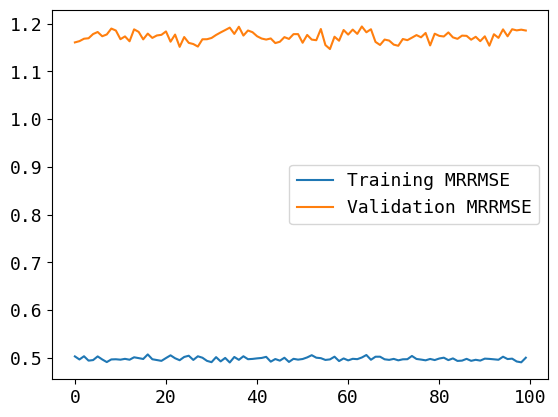

In [11]:
plt.plot(list(range(n_epochs)), trainLossList, label="Training MRRMSE")
plt.plot(list(range(n_epochs)), valLossList, label="Validation MRRMSE")
plt.legend()
plt.show()

### CPA

In [ ]:
de_train_df = pd.read_parquet(DATA_FILEPATH + "/de_train.parquet")
print("Differential Expression - train data")
print(de_train_df.shape)
display(de_train_df.head())

id_map = pd.read_csv(DATA_FILEPATH + "/id_map.csv")
print("ID Map")
print(id_map.shape)
print(id_map.columns)
display(id_map.head())


de_train_obs = de_train_df.iloc[:, 0:5]
split_col = random.choices(["train", "valid"], weights=[0.8, 0.2], k=len(de_train_obs.index))
de_train_obs["split"] = split_col

keys = de_train_obs["sm_name"].unique()
values_lincs = [de_train_obs.loc[de_train_obs["sm_name"] == i, "sm_lincs_id"].iloc[0] for i in keys]
values_smiles = [de_train_obs.loc[de_train_obs["sm_name"] == i, "SMILES"].iloc[0] for i in keys]

sm_lincs_rename = dict(zip(keys, values_lincs))
smiles_rename = dict(zip(keys, values_smiles))

de_test_X = pd.DataFrame(0.0, index=id_map["id"], columns=de_train_X.columns)
display(de_test_X.head())

de_test_obs = id_map[["cell_type", "sm_name"]]
de_test_obs["split"] = "test"
de_test_obs["control"] = False
de_test_obs["sm_lincs_id"] = de_test_obs["sm_name"].map(sm_lincs_rename)
de_test_obs["SMILES"] = de_test_obs["sm_name"].map(smiles_rename)
display(de_test_obs.head())

de_total_x = pd.concat([de_train_X, de_test_X])
de_total_obs = pd.concat([de_train_obs, de_test_obs])

In [ ]:
adata = sc.AnnData(de_total_x, 
                         de_total_obs,
                         var=pd.DataFrame(de_total_x.columns, index=de_total_x.columns))
cpa.CPA.setup_anndata(adata,
                      perturbation_key="sm_name",
                      smiles_key="SMILES",
                      control_group="Dabrafenib",
                      batch_key=None,
                      categorical_covariate_keys=["cell_type"],
                      is_count_data=False)

In [ ]:
trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_pretrain_ae": 30,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 0,
    "mixup_alpha": 0.0,
    "adv_steps": None,
    "n_hidden_adv": 64,
    "n_layers_adv": 3,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "reg_adv": 20.0,
    "pen_adv": 5.0,
    "lr": 0.0003,
    "wd": 4e-07,
    "adv_lr": 0.0003,
    "adv_wd": 4e-07,
    "adv_loss": "cce",
    "doser_lr": 0.0003,
    "doser_wd": 4e-07,
    "do_clip_grad": True,
    "gradient_clip_value": 1.0,
    "step_size_lr": 10,
}

In [ ]:
model = cpa.CPA(adata=adata,
                n_latent=512,
                n_hidden_encoder=1024,
                n_layers_encoder=2,
                n_hidden_decoder=1024,
                n_layers_decoder=2,
                recon_loss="gauss",
                split_key="split",
                train_split="train",
                valid_split="valid",
                test_split="test"
               )

model.train(max_epochs=100000,
            use_gpu=True,
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping_patience=50,
            check_val_every_n_epoch=5,
            save_path=DATA_FILEPATH,
           )

model.save(DATA_FILEPATH + "/basic_DE_extendedTrain_cpa_model", overwrite=True)

In [ ]:
cpa.pl.plot_history(model)

In [ ]:
model.predict(adata, batch_size=1024)
preds = adata.obsm['CPA_pred'][-255:]
pred_df = pd.DataFrame()
pred_df["id"] = de_test_X.index
pred_df = pd.concat([pred_df, pd.DataFrame(preds, columns=de_test_X.columns)], axis=1)
pred_df.to_csv(DATA_FILEPATH + "/IPH_submission_v0.csv", index=False)